# Test comment similarity among readers
Do readers of similar groups (location, experience, engagement) tend to react similarity with respect to the same article?

We look at this in terms of:

- entity mentions
- question content

## Load data

First, load author comment data extracted from prior comments, e.g. location.

In [1]:
import pandas as pd
from datetime import datetime
comment_author_data = pd.read_csv('../../data/nyt_comments/author_comment_social_data.tsv', sep='\t', index_col=False)
date_day_fmt = '%Y-%m-%d'
comment_author_data = comment_author_data.assign(**{
    'date_day' : comment_author_data.loc[:, 'date_day'].apply(lambda x: datetime.strptime(x, date_day_fmt))
})
display(comment_author_data.head())

,userID,date_day,prior_comment_count_bin,prior_comment_len_bin,location_region
0,1045,2017-04-09,1,0,US
1,1045,2018-01-17,0,0,US
2,1045,2018-01-24,0,0,US
3,1072,2017-03-13,1,1,US
4,1072,2018-01-03,0,1,US


In [3]:
## load comments
import os
month_year_pairs = [
        ('Jan', '2017'),
        ('Feb', '2017'),
        ('March', '2017'),
        ('April', '2017'),
        ('Jan', '2018'),
        ('Feb', '2018'),
        ('March', '2018'),
        ('April', '2018'),
    ]
comment_data_dir = '../../data/nyt_comments/'
comment_cols = ['articleID', 'commentBody', 'createDate', 'userID']
comment_data_files = list(map(lambda x: os.path.join(comment_data_dir, f'Comments{x[0]}{x[1]}.csv'), month_year_pairs))
comment_data = list(map(lambda x: pd.read_csv(x, sep=',', index_col=False, usecols=comment_cols), comment_data_files))
comment_data = pd.concat(comment_data, axis=0)
comment_data = comment_data.assign(**{
    'userID' : comment_data.loc[:, 'userID'].astype(int)
})
# remove null comments
comment_data = comment_data[comment_data.loc[:, 'commentBody'].apply(lambda x: type(x) is not float)]
# fix date var
from data_helpers import round_date_to_day
comment_data = comment_data.assign(**{
    'date_day' : comment_data.loc[:, 'createDate'].apply(round_date_to_day)
})
display(comment_data.head())

<ipython-input-3-61d679fddff7>:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  comment_data = pd.concat(comment_data, axis=0)


,articleID,commentBody,createDate,userID,date_day
0,58691a5795d0e039260788b9,For all you Americans out there --- still rejo...,1.483426e+09,64679318,2017-01-03
1,58691a5795d0e039260788b9,Obamas policies may prove to be the least of t...,1.483417e+09,69254188,2017-01-02
2,58691a5795d0e039260788b9,Democrats are comprised of malcontents who gen...,1.483431e+09,76788711,2017-01-03
3,58691a5795d0e039260788b9,The picture in this article is the face of con...,1.483419e+09,72718862,2017-01-02
4,58691a5795d0e039260788b9,Elections have consequences.,1.483417e+09,7529267,2017-01-02


In [4]:
## join data
combined_comment_author_data = pd.merge(comment_author_data, comment_data, on=['userID', 'date_day'])
print(f'{combined_comment_author_data.shape[0]} comments')
display(combined_comment_author_data.head())

1899592 comments


,userID,date_day,prior_comment_count_bin,prior_comment_len_bin,location_region,articleID,commentBody,createDate
0,1045,2017-04-09,1,0,US,58e3609a7c459f24986d83a6,"The ""earliest days of the internet"" were not i...",1.491756e+09
1,1045,2018-01-17,0,0,US,5a5f71d87c459f29e79b46ad,You left out the part where she wrote an anony...,1.516227e+09
2,1045,2018-01-24,0,0,US,5a68592710f40f00018bd70d,"Yes, thank you. Folks need to lighten up. I wo...",1.516816e+09
3,1072,2017-03-13,1,1,US,58c7001c7c459f247805b940,“Try to imagine a … presidential candidate say...,1.489449e+09
4,1072,2018-01-03,0,1,US,5a4e75be7c459f29e79b20c2,Fix the Subways. That this argument has to be...,1.514982e+09


## Test entity overlap
First, let's test the overlap in entities mentioned in the comments, without respect to the article.

In [5]:
## extract entities with NER
import stanza
# help(stanza.Pipeline)
nlp_pipeline = stanza.Pipeline(lang='en', processors='tokenize,ner', use_gpu=True)

2020-12-19 23:44:21 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| ner       | ontonotes |

2020-12-19 23:44:21 INFO: Use device: gpu
2020-12-19 23:44:21 INFO: Loading: tokenize
2020-12-19 23:44:24 INFO: Loading: ner
2020-12-19 23:44:25 INFO: Done loading processors!


In [6]:
def extract_all_named_entities(text, pipeline):
    text_doc = pipeline(text)
    named_entities = []
    for text_sent_i in text_doc.sentences:
        NE_tokens_i = []
        for token_j in text_sent_i.tokens:
            token_j_NE = token_j.ner
            if(token_j_NE != 'O'):
                token_j_text = token_j.text
                if(token_j_NE.startswith('E')):
                    NE_tokens_i.append(token_j_text)
                    NE_final = '_'.join(NE_tokens_i)
                    named_entities.append(NE_final)
                    NE_tokens_i = []
                else:
                    NE_tokens_i.append(token_j_text)
    return named_entities
# print(nlp_pipeline('this is a test for Donald Trump. he is a person.'))
test_text = 'this is a test for Donald Trump. he is a person. the Atlanta Falcons won the game.'
x = nlp_pipeline(test_text)
# print(x.)
print(extract_all_named_entities(test_text, nlp_pipeline))

['Donald_Trump', 'the_Atlanta_Falcons']


Let's sample to avoid hurting our memory.

In [7]:
import numpy as np
np.random.seed(123)
sample_size = 100000
sample_comment_author_data_idx = np.random.choice(combined_comment_author_data.index, sample_size, replace=False)
sample_comment_author_data = combined_comment_author_data.loc[sample_comment_author_data_idx, :]

In [8]:
from tqdm import tqdm
tqdm.pandas()
sample_comment_author_data = sample_comment_author_data.assign(**{
    'named_entities' : sample_comment_author_data.loc[:, 'commentBody'].progress_apply(lambda x: extract_all_named_entities(x, nlp_pipeline))
})

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
 10%|▉         | 9526/100000 [10:24<1:24:26, 17.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 41%|████      | 40795/100000 [42:21<55:11, 17.88it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (s

In [9]:
display(sample_comment_author_data.head())

,userID,date_day,prior_comment_count_bin,prior_comment_len_bin,location_region,articleID,commentBody,createDate,named_entities
438434,30569608,2017-01-23,0,0,US,5885282895d0e0392607c266,Just watched Sean Splicer's news briefing. He ...,1.485213e+09,[Sean_Splicer_'s]
201060,12698735,2017-01-18,1,1,non_US,587e66d195d0e0392607b2ee,Glad to hear I'm not the only one who cries at...,1.484776e+09,[Chef_Howard]
66777,2258463,2018-03-24,1,1,US,5ab6993247de81a901216a6a,"Perhaps a better analogy: Hiroshima, destructi...",1.521944e+09,[]
1215272,63735584,2017-04-05,0,0,US,58de28ac7c459f24986d7a00,"I am losing weight, slowly, at the age of 64 f...",1.491395e+09,[the_age_of_64]
1579567,71835948,2017-02-05,0,0,non_US,58962bcf95d0e0392607ea60,"How does an ""originalist"" ever get to Brown v....",1.486312e+09,[Brown_v._Board_of_Education]


In [11]:
## write to file temporarily, then restart kernel to fix memory
sample_comment_author_data.to_csv('../../data/nyt_comments/sample_author_comment_entities.gz', sep='\t', compression='gzip', index=False)

In [1]:
import pandas as pd
sample_comment_author_data = pd.read_csv('../../data/nyt_comments/sample_author_comment_entities.gz', sep='\t', compression='gzip', index_col=False)

In [2]:
from ast import literal_eval
sample_comment_author_data = sample_comment_author_data.assign(**{
    'NE_list' : sample_comment_author_data.loc[:, 'named_entities'].apply(literal_eval)
})
display(sample_comment_author_data.head())

,userID,date_day,prior_comment_count_bin,prior_comment_len_bin,location_region,articleID,commentBody,createDate,named_entities,NE_list
0,30569608,2017-01-23,0,0,US,5885282895d0e0392607c266,Just watched Sean Splicer's news briefing. He ...,1.485213e+09,"[""Sean_Splicer_'s""]",[Sean_Splicer_'s]
1,12698735,2017-01-18,1,1,non_US,587e66d195d0e0392607b2ee,Glad to hear I'm not the only one who cries at...,1.484776e+09,['Chef_Howard'],[Chef_Howard]
2,2258463,2018-03-24,1,1,US,5ab6993247de81a901216a6a,"Perhaps a better analogy: Hiroshima, destructi...",1.521944e+09,[],[]
3,63735584,2017-04-05,0,0,US,58de28ac7c459f24986d7a00,"I am losing weight, slowly, at the age of 64 f...",1.491395e+09,['the_age_of_64'],[the_age_of_64]
4,71835948,2017-02-05,0,0,non_US,58962bcf95d0e0392607ea60,"How does an ""originalist"" ever get to Brown v....",1.486312e+09,['Brown_v._Board_of_Education'],[Brown_v._Board_of_Education]


In [3]:
## clean up NEs
import re
POSS_MATCHER = re.compile("_'s$") # possessive
ARTICLE_MATCHER = re.compile('^(the|a|an)_') # article
def clean_NE(NE):
    NE = POSS_MATCHER.sub('', NE)
    NE = ARTICLE_MATCHER.sub('', NE)
    return NE
sample_comment_author_data = sample_comment_author_data.assign(**{
    'NE_list' : sample_comment_author_data.loc[:, 'NE_list'].apply(lambda x: list(map(lambda y: clean_NE(y), x)))
})

In [4]:
## count most frequent NEs
sample_NEs = []
for NE_i in sample_comment_author_data.loc[:, 'NE_list'].values:
    sample_NEs.extend(NE_i)
sample_NEs = pd.Series(sample_NEs).value_counts()
print(sample_NEs.head(10))

Donald_Trump        1518
White_House         1106
United_States        979
Paul_Ryan            469
Hillary_Clinton      432
North_Korea          406
Supreme_Court        402
New_York             340
Republican_Party     328
NY_Times             314
dtype: int64


Do people in the same reader group tend to mention the same entities in response to the same article?

We'll compare the entity overlap among reader groups (aggregate) versus entity overlap among randomly-grouped people.

Later: we'll compare at the level of news sections to address topical effects.

In [21]:
# a = pd.Series([1,0], ['Trump', 'Clinton'])
# print(a)
# print(a.reindex(['Trump', 'Clinton', 'Sanders']).replace(np.nan, 0.))
print(help(pd.Series.reindex))

Help on function reindex in module pandas.core.series:

reindex(self, index=None, **kwargs)
    Conform Series to new index with optional filling logic, placing
    NA/NaN in locations having no value in the previous index. A new object
    is produced unless the new index is equivalent to the current one and
    ``copy=False``.
    
    Parameters
    ----------
    
    index : array-like, optional
        New labels / index to conform to, should be specified using
        keywords. Preferably an Index object to avoid duplicating data
    
    method : {None, 'backfill'/'bfill', 'pad'/'ffill', 'nearest'}
        Method to use for filling holes in reindexed DataFrame.
        Please note: this is only applicable to DataFrames/Series with a
        monotonically increasing/decreasing index.
    
        * None (default): don't fill gaps
        * pad / ffill: propagate last valid observation forward to next
          valid
        * backfill / bfill: use next valid observation to fill 

In [52]:
from functools import reduce
import numpy as np
from scipy.spatial.distance import cosine
def compute_NE_dist(NE_list_1, NE_list_2):
    """
    Compute distance between NE lists based on
    frequency difference.
    """
    NE_counts_1 = pd.Series(list(reduce(lambda x,y: x+y, NE_list_1))).value_counts()
    NE_counts_2 = pd.Series(list(reduce(lambda x,y: x+y, NE_list_2))).value_counts()
    # default value (no NEs) => -1
    if(len(NE_counts_1) == 0 and len(NE_counts_2) == 0):
        return np.nan
    else:
        # combine index
        NE_combined = list(set(NE_counts_1.index) | set(NE_counts_2.index))
        NE_counts_1 = NE_counts_1.reindex(NE_combined, fill_value=0.)
        NE_counts_2 = NE_counts_2.reindex(NE_combined, fill_value=0.)
        # normalize
        NE_counts_1 = (NE_counts_1 / NE_counts_1.sum()).fillna(0.)
        NE_counts_2 = (NE_counts_2 / NE_counts_2.sum()).fillna(0.)
#         print(NE_counts_1)
#         print(NE_counts_2)
        # compute difference
#         NE_count_diff = NE_counts_1 - NE_counts_2
#         NE_count_diff = (NE_count_diff**2.).sum()**.5
        NE_count_diff = cosine(NE_counts_1, NE_counts_2)
        return NE_count_diff

In [51]:
cosine([0.5, 0.5], [0., 0.])

nan

In [60]:
from scipy.stats import mannwhitneyu
import numpy as np
np.random.seed(123)
author_group_vars = ['prior_comment_count_bin', 'prior_comment_len_bin', 'location_region']
pair_sample_size = 1000
for author_group_var_i in author_group_vars:
    author_group_vals_i = set(sample_comment_author_data.loc[:, author_group_var_i].unique())
    ## compute paired similarity
    paired_diffs = []
    unpaired_diffs = []
    for author_group_val_j, data_j in sample_comment_author_data.groupby(author_group_var_i):
        print(f'testing var={author_group_var_i} for value={author_group_val_j}')
        # randomly sample N author pairs
        authors_j = data_j.loc[:, 'userID'].unique()
        for k in range(pair_sample_size):
            authors_k = np.random.choice(authors_j, 2, replace=False)
            author_1_k, author_2_k = authors_k
            data_1_k = data_j[data_j.loc[:, 'userID']==author_1_k]
            data_2_k = data_j[data_j.loc[:, 'userID']==author_2_k]
            NE_1_k = data_1_k.loc[:, 'NE_list'].values
            NE_2_k = data_2_k.loc[:, 'NE_list'].values
            NE_count_diff_k = compute_NE_dist(NE_1_k, NE_2_k)
#             if(np.isnan(NE_count_diff_k)):
#                 print(f'nan value for NEs 1 = {NE_1_k}; NEs 2 = {NE_2_k}')
#                 break
            paired_diffs.append(NE_count_diff_k)
        ## compute randomly-paired similarity
        other_authors_j = sample_comment_author_data[~sample_comment_author_data.loc[:, 'userID'].isin(authors_j)].loc[:, 'userID'].unique()
        # get pair from both groups, compute difference
        np.random.shuffle(authors_j)
        np.random.shuffle(other_authors_j)
        for group_author_k, other_group_author_k in zip(authors_j[:pair_sample_size], other_authors_j):
            data_1_k = data_j[data_j.loc[:, 'userID']==group_author_k]
            data_2_k = sample_comment_author_data[sample_comment_author_data.loc[:, 'userID']==other_group_author_k]
            NE_1_k = data_1_k.loc[:, 'NE_list'].values
            NE_2_k = data_2_k.loc[:, 'NE_list'].values
            NE_count_diff_k = compute_NE_dist(NE_1_k, NE_2_k)
            unpaired_diffs.append(NE_count_diff_k)
    ## compare
    paired_diffs = np.array(paired_diffs)
    unpaired_diffs = np.array(unpaired_diffs)
    paired_diffs = paired_diffs[~np.isnan(paired_diffs)]
    unpaired_diffs = unpaired_diffs[~np.isnan(unpaired_diffs)]
    print('mean paired diff = %.3E'%(np.mean(paired_diffs)))
    print('mean unpaired diff = %.3E'%(np.mean(unpaired_diffs)))
    test_stat, p_val = mannwhitneyu(paired_diffs, unpaired_diffs)
    print('test stat = %.3f (p=%.3E)'%(test_stat, p_val))

testing var=prior_comment_count_bin for value=0
testing var=prior_comment_count_bin for value=1
mean paired diff = 9.976E-01
mean unpaired diff = 9.992E-01
test stat = 214574.000 (p=2.221E-01)
testing var=prior_comment_len_bin for value=0
testing var=prior_comment_len_bin for value=1
mean paired diff = 9.985E-01
mean unpaired diff = 9.985E-01
test stat = 246251.000 (p=2.897E-01)
testing var=location_region for value=US
testing var=location_region for value=non_US
mean paired diff = 9.978E-01
mean unpaired diff = 9.982E-01
test stat = 241871.000 (p=3.963E-01)


Not great! We see a very small difference in means for prior comment counts and for location, but not significant.

This is likely a data sparsity issue, since most of the authors only write one comment.
Let's try to scale this up:

- for each author group, sample $M_1$ authors and $M_2$ authors, then compute their NE similarity
- for each author group, sample $M_1$ authors in-group and $M_2$ authors out-of-group, then compute their NE similarity

In [71]:
from scipy.stats import mannwhitneyu
import numpy as np
np.random.seed(123)
author_group_vars = ['prior_comment_count_bin', 'prior_comment_len_bin', 'location_region']
pair_sample_size = 1000
group_sample_size = 200
combined_diff_data = []
for author_group_var_i in author_group_vars:
    author_group_vals_i = set(sample_comment_author_data.loc[:, author_group_var_i].unique())
    ## compute paired similarity
    paired_diffs = []
    unpaired_diffs = []
    for author_group_val_j, data_j in sample_comment_author_data.groupby(author_group_var_i):
        print(f'testing var={author_group_var_i} for value={author_group_val_j}')
        # randomly sample N author pairs
        authors_j = data_j.loc[:, 'userID'].unique()
        for k in range(pair_sample_size):
            authors_k = np.random.choice(authors_j, 2, replace=False)
            author_1_k = np.random.choice(authors_j, group_sample_size, replace=False)
            author_2_k_pool = list(set(authors_j) - set(author_1_k))
            author_2_k = np.random.choice(author_2_k_pool, min(group_sample_size, len(author_2_k_pool)), replace=False)
            data_1_k = data_j[data_j.loc[:, 'userID'].isin(author_1_k)]
            data_2_k = data_j[data_j.loc[:, 'userID'].isin(author_2_k)]
            NE_1_k = data_1_k.loc[:, 'NE_list'].values
            NE_2_k = data_2_k.loc[:, 'NE_list'].values
            NE_count_diff_k = compute_NE_dist(NE_1_k, NE_2_k)
            paired_diffs.append(NE_count_diff_k)
        ## compute randomly-paired similarity
        other_authors_j = sample_comment_author_data[~sample_comment_author_data.loc[:, 'userID'].isin(authors_j)].loc[:, 'userID'].unique()
        for k in range(pair_sample_size):
            authors_k = np.random.choice(authors_j, group_sample_size, replace=False)
            other_authors_k = np.random.choice(other_authors_j, group_sample_size, replace=False)
            data_1_k = data_j[data_j.loc[:, 'userID'].isin(authors_k)]
            data_2_k = sample_comment_author_data[sample_comment_author_data.loc[:, 'userID'].isin(other_authors_k)]
            NE_1_k = data_1_k.loc[:, 'NE_list'].values
            NE_2_k = data_2_k.loc[:, 'NE_list'].values
            NE_count_diff_k = compute_NE_dist(NE_1_k, NE_2_k)
            unpaired_diffs.append(NE_count_diff_k)
    ## compare
    paired_diffs = np.array(paired_diffs)
    unpaired_diffs = np.array(unpaired_diffs)
    paired_diffs = paired_diffs[~np.isnan(paired_diffs)]
    unpaired_diffs = unpaired_diffs[~np.isnan(unpaired_diffs)]
    print('median paired diff = %.3E'%(np.median(paired_diffs)))
    print('median unpaired diff = %.3E'%(np.median(unpaired_diffs)))
    test_stat, p_val = mannwhitneyu(paired_diffs, unpaired_diffs)
    print('test stat = %.3f (p=%.3E)'%(test_stat, p_val))
    diff_data_i = pd.DataFrame(
        [paired_diffs, unpaired_diffs, 
         [author_group_var_i,]*(pair_sample_size*2), 
         list(range(pair_sample_size*2))],
        index=['paired_diff', 'unpaired_diff', 'author_group', 'sample']
    ).transpose()
    combined_diff_data.append(diff_data_i)
combined_diff_data = pd.concat(combined_diff_data)

testing var=prior_comment_count_bin for value=0
testing var=prior_comment_count_bin for value=1
median paired diff = 8.099E-01
median unpaired diff = 8.148E-01
test stat = 1860181.000 (p=6.443E-05)
testing var=prior_comment_len_bin for value=0
testing var=prior_comment_len_bin for value=1
median paired diff = 7.959E-01
median unpaired diff = 8.109E-01
test stat = 1837581.000 (p=4.345E-06)
testing var=location_region for value=US
testing var=location_region for value=non_US
median paired diff = 7.982E-01
median unpaired diff = 8.029E-01
test stat = 1922489.000 (p=1.690E-02)


,diff,author_group,diff_type
0,0.777923,location_region,intra-group
1,0.791526,location_region,intra-group
2,0.814428,location_region,intra-group
3,0.83328,location_region,intra-group
4,0.872686,location_region,intra-group


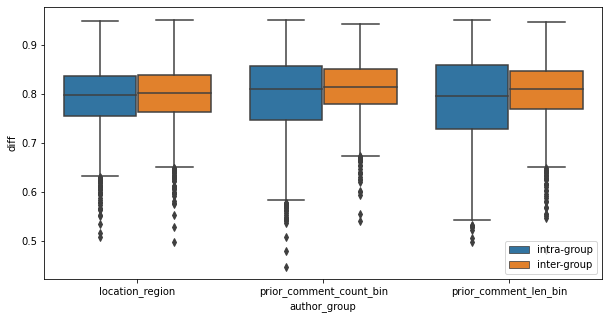

In [78]:
# ## plot differences
# # flatten data for plotting
# flat_diff_data = []
# for group_i, data_i in combined_diff_data.groupby('author_group'):
#     pair_data_i = data_i.loc[:, ['paired_diff', 'author_group']].rename(columns={'paired_diff':'diff'}).assign(**{'diff_type' : 'intra-group'})
#     unpair_data_i = data_i.loc[:, ['unpaired_diff', 'author_group']].rename(columns={'unpaired_diff':'diff'}).assign(**{'diff_type' : 'inter-group'})
#     flat_diff_data.extend([pair_data_i, unpair_data_i])
# flat_diff_data = pd.concat(flat_diff_data, axis=0)
display(flat_diff_data.head())
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.boxplot(data=flat_diff_data, x='author_group', y='diff', hue='diff_type')
plt.legend(loc='lower right')
plt.show()

OK! This is more what I expected. The author groups have (slightly) lower intra-group difference than inter-group difference.

### Test question similarity
Now that we've established that readers in the same group tend to mention similar NEs, can we determine if readers in the same group ask similar questions?

For this we need a more complicated approach.
Let's look first at the type of question based on `information elicited` ("what", "where", "why", "how", "who").
If necessary, we'll scale up by converting questions to latent semantic space and computing their similarity.